<a href="https://colab.research.google.com/github/qaixerabbas/ai-notebooks/blob/master/Kaggle_Dataset_Download_to_Drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !ln -s /con

In [2]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 2.2MB/s 
     |████████████████████████████████| 5.3MB 14.8MB/s 
     |████████████████████████████████| 112kB 48.1MB/s 
     |████████████████████████████████| 51kB 3.8MB/s 
     |████████████████████████████████| 133kB 44.8MB/s 


In [6]:
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/kaggle.json" ~/.kaggle/

In [7]:
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json

{"username":"ezii58","key":"b4d1f9ffe8af7259fd321e0edd067c50"}

In [8]:
# # For competition datasets --> downloading the dataset from Kaggle competetions
# !kaggle competitions download -c dataset_name -p download_to_folder

In [17]:
# kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign
!pwd

/content


In [13]:
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [19]:
# For other datasets
# !kaggle datasets download -d user/dataset_name -p download_to_folder
# !kaggle datasets download -d fanconi/skin-cancer-malignant-vs-benign -p /content/drive/My\ Drive/Kaggle/
#dataset is downloaded in the !pwd Present Working Directory
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 97% 314M/325M [00:02<00:00, 126MB/s]
100% 325M/325M [00:02<00:00, 114MB/s]


In [20]:
!ls

'Kaggle Dataset Download to Drive.ipynb'   skin-cancer-malignant-vs-benign.zip


In [21]:
!unzip skin-cancer-malignant-vs-benign.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/benign/420.jpg  
  inflating: data/train/benign/421.jpg  
  inflating: data/train/benign/422.jpg  
  inflating: data/train/benign/423.jpg  
  inflating: data/train/benign/424.jpg  
  inflating: data/train/benign/425.jpg  
  inflating: data/train/benign/426.jpg  
  inflating: data/train/benign/429.jpg  
  inflating: data/train/benign/43.jpg  
  inflating: data/train/benign/430.jpg  
  inflating: data/train/benign/431.jpg  
  inflating: data/train/benign/432.jpg  
  inflating: data/train/benign/434.jpg  
  inflating: data/train/benign/435.jpg  
  inflating: data/train/benign/438.jpg  
  inflating: data/train/benign/439.jpg  
  inflating: data/train/benign/440.jpg  
  inflating: data/train/benign/441.jpg  
  inflating: data/train/benign/442.jpg  
  inflating: data/train/benign/443.jpg  
  inflating: data/train/benign/445.jpg  
  inflating: data/train/benign/446.jpg  
  inflating: data/train/benign/447.jpg  
  infla

**Implementing a TFHUB Model for Transfer Learning**
This will be now used to detect the skin cancer

In [22]:
#Tensorflow and Tensorflow Hub Installation
%%capture
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu=2.0.0-beta1
!pip install -q tensorflow_hub

In [14]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [15]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

65536/61306 [================================] - 0s 0us/step


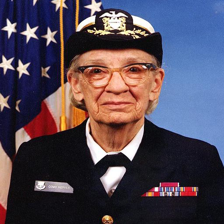

In [16]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [17]:
#Normalize the image
grace_hopper = np.array(grace_hopper)/255
grace_hopper.shape #(224, 224, 3)

#Add a new axis for batch no and predict
results = classifier.predict(grace_hopper[np.newaxis, ...])
results #array([[ 0.17920303,  1.2696182 , -0.3149821 , ...,  0.6060541 ,
        #-0.4299778 ,  0.11200593]], dtype=float32)
#The result is a 1001 vector of logits rating the probability of each class for the image

#The top class ID can be found by argmax
predicted_class = np.argmax(results[0], axis=-1)
predicted_class #653

653

16384/10484 [==============================================] - 0s 0us/step


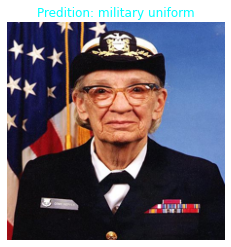

In [18]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
imagenet_labels
#array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
#       'toilet tissue'], dtype='<U30')

#Let's plot the image with the predicted label
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title('Predition: '+ predicted_class_name, color='cyan')

**Now Using Pretrained MobileNet V2 and training it on the Skin Cancer Dataset**

In [19]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

#Create the feature extractor
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=IMAGE_SHAPE+(3,))
# feature_batch = feature_extractor_layer(image_batch)
# print(feature_batch.shape)  #(32, 1280)

In [20]:
feature_extractor_layer.trainable = False #Important

In [21]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(2, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [24]:
# import matplotlib
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import LearningRateScheduler
# from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from pyimagesearch.cancernet import CancerNet
# from pyimagesearch import config
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
# import argparse
import os

In [25]:
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.05,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")
# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

**Settting the paths of testing and training images**

In [26]:
train = "/content/drive/My Drive/Kaggle/data/train"
val = "/content/drive/My Drive/Kaggle/data/test"

In [27]:
BS = 16
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	train,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=BS)
# initialize the testing generator
testGen = valAug.flow_from_directory(
	val,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [28]:
# samples = 2637+660
# samples

In [29]:
class ConnectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_train_batch_end(self, batch, logs=False):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    self.model.reset_metrics()
    
# steps_per_epoch = np.ceil(samples/BS)

batch_stats_callback = ConnectBatchStats()

In [30]:
validation_steps = 660 // BS
steps_per_epoch = 2637 // BS

In [31]:
history = model.fit_generator(trainGen,
                   epochs = 15,
                   validation_data=testGen,
                   steps_per_epoch = steps_per_epoch,
                   validation_steps = validation_steps,
                   callbacks = [batch_stats_callback])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
164/164 [==============================] - 1254s 8s/step - loss: 0.4806 - accuracy: 0.7735 - val_loss: 0.4237 - val_accuracy: 0.8110
Epoch 2/15
164/164 [==============================] - 35s 211ms/step - loss: 0.3702 - accuracy: 0.8257 - val_loss: 0.3879 - val_accuracy: 0.8216
Epoch 3/15
164/164 [==============================] - 35s 212ms/step - loss: 0.3381 - accuracy: 0.8496 - val_loss: 0.3746 - val_accuracy: 0.8247
Epoch 4/15
164/164 [==============================] - 35s 211ms/step - loss: 0.3389 - accuracy: 0.8431 - val_loss: 0.4229 - val_accuracy: 0.8095
Epoch 5/15
164/164 [==============================] - 35s 212ms/step - loss: 0.3315 - accuracy: 0.8539 - val_loss: 0.3801 - val_accuracy: 0.8308
Epoch 6/15
164/164 [==============================] - 35s 211ms/step - loss: 0.3245 - accuracy: 0.8620 - val_loss: 0.3634 - val_accuracy: 0.8369
Epoch 7/15
164/164 [==============================] - 35s 210ms/step - loss: 0.3096 - accuracy: 0.8710 - val_loss: 0.3762 - val_acc

In [48]:
 !pip install h5py 

In [2]:
# self.alpha = self.add_weight(shape=(self.nout,), initializer='zeros',
#                          trainable=True, name="alpha")

# self.beta = self.add_weight(shape=(self.nout,), initializer='zeros',
#                          trainable=True, name="beta")

In [3]:
# # model.save('/content/drive/My Drive/Kaggle/melanoma_model.h5')
# model.save_weights('/content/drive/My Drive/Kaggle/melanoma_weights.h5')

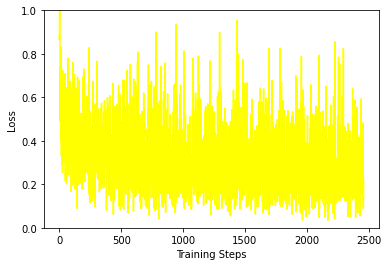

In [32]:
plt.figure()
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.plot(batch_stats_callback.batch_losses, color='yellow')

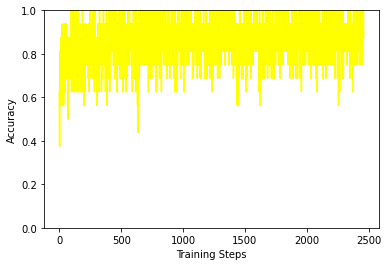

In [33]:
plt.figure()
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.plot(batch_stats_callback.batch_acc, color='yellow')

In [1]:
# save_here='Saved_Model.h5'
# model.save(save_here, save_format='h5')

In [4]:
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


**Inference using the trained model and saved weights**

In [34]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(val, target_size=IMAGE_SHAPE)
#Found 3670 images belonging to 5 classes.

#The resulting is an iterator that returns image_batch and label_batch pairs
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break
#Image batch shape:  (32, 224, 224, 3)
#Label batch shape:  (32, 5)

Found 660 images belonging to 2 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


In [35]:
class_names = sorted(image_data.class_indices.items(), key = lambda pair : pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Benign', 'Malignant'], dtype='<U9')

In [36]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

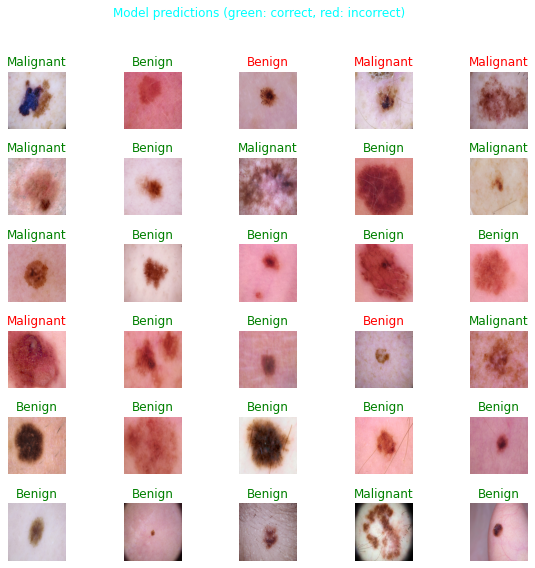

In [37]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  color = 'green' if predicted_id[n] == label_id[n] else 'red'
  plt.title(predicted_label_batch[n], color = color)
  plt.axis('off')

_=plt.suptitle('Model predictions (green: correct, red: incorrect)', color='cyan')